<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_10_Unsupervised_Learning_Examples_and_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Example: Uncovering Patient Types

# 1. Objectives

To understand the type of patients who got admitted to ICU and compare the patient groups in terms of in-hospital mortality rate.

---

# 2. Setting up

**Packages for data handling and visualization**

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()

import os

**Packages for data analysis and modelling**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

**Authentication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in Week 5 notebook, grant Colab access to your Google Drive and import it to the current notebook. You would need to authenticate yourself.

Alternatively, when you are working on your own analysis, you may also put everything (i.e. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment.


In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


If you have followed the previous tutorial and execute all codes, a file named 'mimic_in_hosp_death_clean.csv' should appear in your Google Drive. In that case you can directly import it into the current notebook. Otherwise, you can download the intermediate dataset using the link below.

In [ ]:
if os.path.exists(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv'):
  print('Importing file from Google Drive...')
  df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')
else:
  print('Importing file from external link...')
  df = pd.read_csv('https://dl.dropboxusercontent.com/s/0g9rio6jz5zb8ow/mimic_in_hosp_death_clean.csv')

Importing file from Google Drive...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,3115,134067,EMERGENCY,2139-02-13 03:11:00,2139-02-20 07:33:00,NaN,STAB WOUND,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
1,7124,109129,EMERGENCY,2188-07-11 00:58:00,2188-08-01 12:04:00,NaN,PENILE LACERATION-CELLULITIS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
2,10348,121510,EMERGENCY,2133-04-16 21:12:00,2133-04-23 15:52:00,NaN,STATUS EPILEPTICUS,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,0,0,1,0
3,9396,106469,EMERGENCY,2109-02-16 23:14:00,2109-02-23 12:01:00,NaN,SUBDURAL HEMATOMA,UNKNOWN (DEFAULT),Medicare,ENGL,...,1,0,1,0,0,0,1,0,0,0
4,9333,133732,URGENT,2167-10-06 18:35:00,2167-10-16 13:13:00,NaN,CORONARY ARTERY DISEASE,UNKNOWN (DEFAULT),Private,ENGL,...,1,0,1,0,0,0,0,0,1,0


---

# 3. Principal Component Analysis (PCA)

PCA is a technique for **dimensionality reduction**, which is the process of reducing the number of features in a dataset. It aims to **eliminate redundancy** in variables while **preserving important information**.

As the number of predictor variables increases, the manageability and effectiveness of the data tend to decrease. On a high level, as we introduce extra variables to a data set, the average and minimum distance between each data point increase.

In terms of analytics, creating good predictions then becomes more difficult as the distance between the known points and the unknown points increases. Additionally, **features** in your data set **may not add much value** or predictive power in the context of the target (independent) variable. These features do not improve the model but **increase noise** in the dataset, as well as the overall computational load of the model.

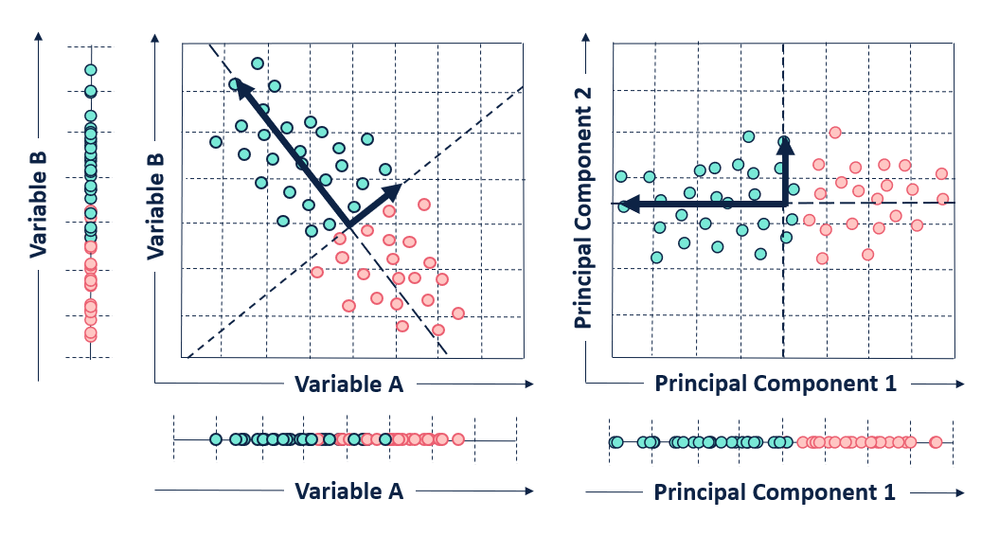

([Source](https://community.alteryx.com/t5/Data-Science/Tidying-up-with-PCA-An-Introduction-to-Principal-Components/ba-p/382557?lightbox-message-images-382557=57362iD2D444D4C9F7F0A8))

Here, we attempt to reduce the dataset into **smaller set of variables** by using PCA. By evaluating the extracted principal components (PC), we can also know which variables contain the most unique information and which variables are redundant.

In [ ]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU',
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY',
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT',
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS',
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

In [ ]:
X = df[features_list]

# note that we do not define y as we do not have a prediction target in PCA or unsupervised learning in general

Before we do PCA, it is important to **scale all input variables to zero mean and unit variance** via `StandardScaler()` because the scale of variables matters in PCA (and most machine learning algorithms, but logistic regression and random forest are exceptions). For example, `GENDER_F`, `AGE` and `INPUTS_CV_COUNT_DAY` all have vastly different ranges, as shown below.

In [ ]:
X[['GENDER_F', 'AGE', 'INPUTS_CV_COUNT_DAY']].describe()

,GENDER_F,AGE,INPUTS_CV_COUNT_DAY
count,58976.000000,58976.000000,58976.000000
mean,0.441298,54.718021,22.424710
std,0.496546,27.126279,46.460934
min,0.000000,0.000000,0.000000
25%,0.000000,43.000000,0.000000
50%,0.000000,61.000000,2.664379
75%,1.000000,75.000000,26.248431
max,1.000000,90.000000,1176.000000


In [ ]:
# normalise/standardise all input columns
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [ ]:
# after scaling, all columns have mean around 0 and standard deviation around 1
X[['GENDER_F', 'AGE', 'INPUTS_CV_COUNT_DAY']].describe()

,GENDER_F,AGE,INPUTS_CV_COUNT_DAY
count,5.897600e+04,5.897600e+04,5.897600e+04
mean,1.927680e-17,9.060095e-17,4.975823e-17
std,1.000008e+00,1.000008e+00,1.000008e+00
min,-8.887426e-01,-2.017176e+00,-4.826614e-01
25%,-8.887426e-01,-4.319841e-01,-4.826614e-01
50%,-8.887426e-01,2.315847e-01,-4.253143e-01
75%,1.125185e+00,7.476938e-01,8.230039e-02
max,1.125185e+00,1.300668e+00,2.482914e+01


---

## 3.1. Training

We can use the function `PCA()` from Scikit-learn to perform PCA. Similar to other Scikit-learn models, we first define a model, then train it using `.fit()`. Here, we specify that we want to retain 10 PCs.

It is advisable to start with a smaller number of PCs and see if the explained variance ratio is satisfactory (depending on size and quality of dataset, this could range between 60% to 99%). If this number is too low, you could increase the number of PCs through the input `n_components` then retrain your model. Note that having more PCs could limit the explainability or understandability of your model, especially under a clinical context using real-life data.

In [ ]:
# 1. Specify a model to be trained
model_pca = PCA(n_components = 10, random_state = 1)

# 2. Train the model
model_pca.fit(X)

PCA(n_components=10, random_state=1)

After training the model, we should first use `.explained_variance_ratio_` to check how much variance from the original features is retained by the PCs. In this case, we add them up and we can see that a total of 59.3% of the variance is retained from the first 10 PCs.

In [ ]:
model_pca.explained_variance_ratio_

array([0.13727775, 0.06993676, 0.06735501, 0.06333834, 0.05351955,
       0.04916337, 0.04207231, 0.03900206, 0.03824385, 0.03344249])

In [ ]:
sum(model_pca.explained_variance_ratio_)

0.5933514808287134

<Axes: xlabel='Number of Principal Components', ylabel='Cumulative Explained Variance'>

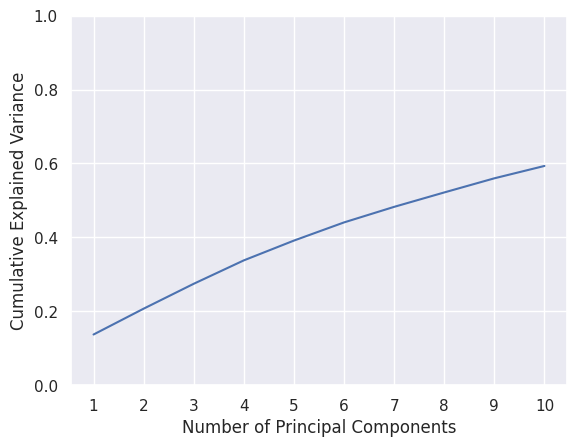

In [ ]:
g = sns.lineplot(
    x = range(1, 1 + model_pca.n_components),
    y = np.cumsum(model_pca.explained_variance_ratio_)
)

# additional customisation for the output graph
g.set(
    xlabel = 'Number of Principal Components',
    ylabel = 'Cumulative Explained Variance',
    xticks = range(1, 1 + model_pca.n_components),
    ylim = [0, 1]
)
g

---

## 3.2. Item Loadings

To understand what information is captured from each PC, we can evaluate their respective item loadings. In the code below, we first apply the formula for computing item loadings, then convert the results to a DataFrame for easier use later.

In [ ]:
df_pca_loadings = pd.DataFrame(
    data = model_pca.components_.T * np.sqrt(model_pca.explained_variance_) / \
      np.std(X).values.reshape((len(features_list), 1)), # equation to compute item loadings
    index = features_list,  # list of row names
    columns = ['PC' + str(i + 1) for i in range(model_pca.n_components_)] # list of column names
).rename_axis('Feature')

df_pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Feature,,,,,,,,,,
GENDER_F,0.011097,-0.041576,0.087190,-0.132919,0.193543,0.216253,0.266696,-0.031857,0.238159,-0.049106
AGE,0.820215,-0.250250,0.175060,-0.172030,-0.159348,0.148691,-0.037820,-0.036026,-0.053871,-0.013814
LOS,-0.126043,-0.257365,0.644270,0.440558,0.128928,-0.239442,-0.019622,0.015588,0.136009,-0.082977
LOS_ICU,-0.170398,-0.162311,0.530979,0.583000,0.156148,-0.171611,0.037773,0.067293,0.208322,-0.089950
CALLOUT_COUNT_DAY,0.302399,0.135419,-0.219885,-0.342013,0.076863,-0.227529,-0.026178,0.005535,0.037627,-0.104630
PRES_COUNT_DAY,0.664652,0.269782,-0.352903,0.192997,0.028104,-0.037872,0.055361,0.009497,0.197530,-0.112519
PROC_COUNT_DAY,0.240573,0.267633,-0.425995,0.288890,-0.103076,0.267738,0.076446,0.023696,0.024489,0.067003
CPT_COUNT_DAY,0.624096,0.240213,-0.071863,0.149979,0.241766,-0.206634,0.064523,0.151372,0.075665,-0.228876
LAB_COUNT_DAY,0.644130,0.265195,-0.226934,0.442771,0.069126,0.134860,0.047825,0.026431,0.013503,0.098474


For the first 5 PCs, we then extract the important features, defined as the ones with the loadings > 0.5 or < -0.5 (you may change this threshold to show a different number of features).

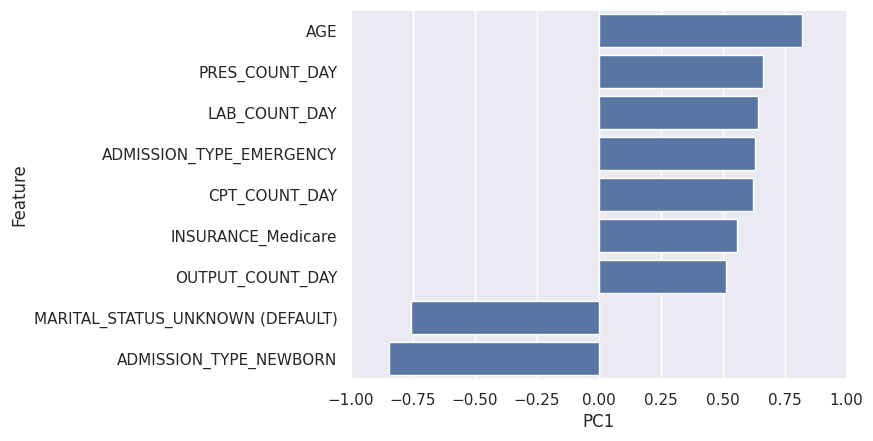

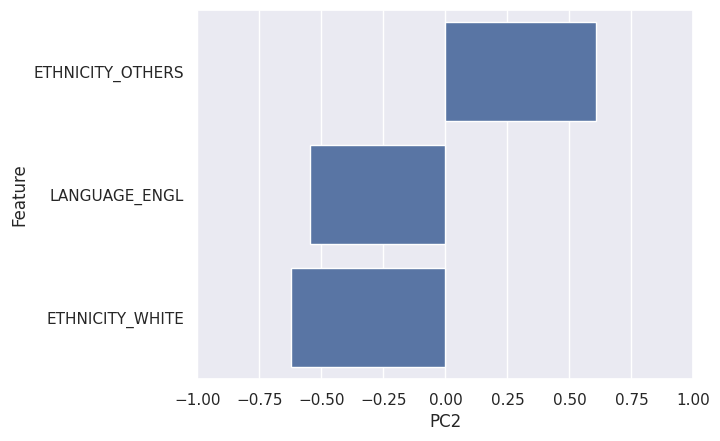

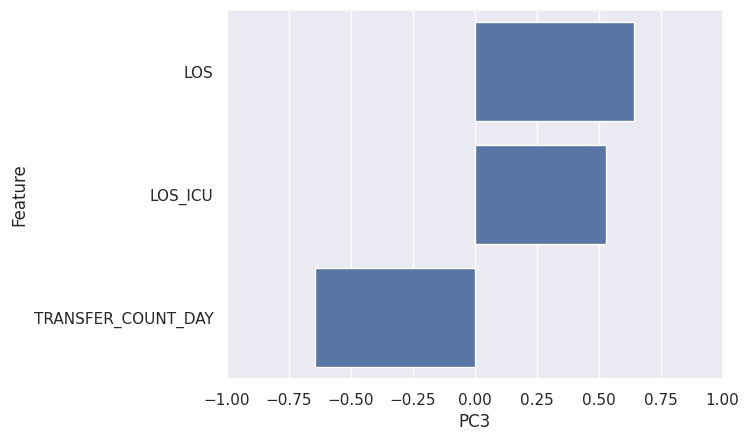

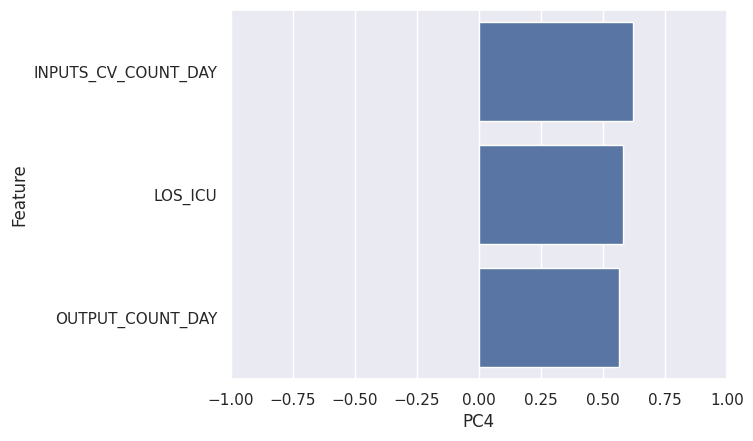

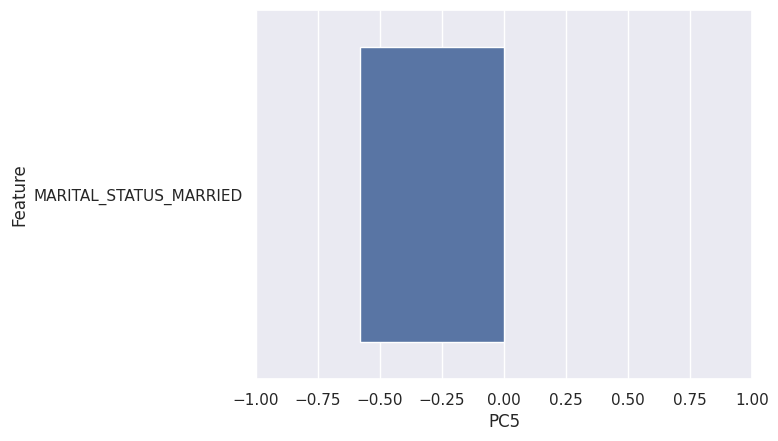

In [ ]:
for col_name in df_pca_loadings.columns[:5]:
  # Sort the item loadings
  tmp_df = df_pca_loadings[col_name].sort_values(key = lambda value: abs(value), ascending = False) \
    .sort_values(ascending = False)

  # Only retain the important features
  # you can adjust this threshold to see more/less features
  tmp_df = tmp_df[abs(tmp_df) > 0.5]

  # plot it
  g = sns.barplot(x = tmp_df, y = tmp_df.index)
  g.set(xlim = [-1, 1])
  plt.show()
  print()

We typically only focus on the first few PCs as they explain the most variance. The table below summarises the meaning for each PC after examining the item loadings:

PC | Explained Variance | Key Features
---|---|---
1 | 13.7% | Age, Daily average lab and prescription events
2 | 7.0% | Demographics (Ethnicity, Language)
3 | 6.7% | Length of Stay
4 | 6.3% | Daily average input and output events
5 | 5.4% | Demographics (Marital status, Language, Ethnicity)


---

# 4. Clustering

Clustering refers to a technique of partitioning entities or objects (e.g. patients, diseases) with similar characteristics into distinct groups while maximizing dissimilarity between groups. In clinical datasets, the major objectives of performing clustering could be to:

* Extract insights from the dataset. **Understand** what **subgroups or phenotypes** exist within the dataset. (e.g. [discovering asthma subtypes](https://pubmed.ncbi.nlm.nih.gov/18480428/))
* Evaluate the **association** between extracted subgroups with other variables or **clinical outcomes**. (e.g. [subgroups of adult-onset diabetes and their association with outcomes](https://pubmed.ncbi.nlm.nih.gov/29503172/))
* Use the extracted patient groups as one of the features or outcome in a **subsequent prediction model**. (e.g. [modelling and predicting osteoarthritis progression](https://pubmed.ncbi.nlm.nih.gov/30130590/))

K-means clustering and hierachical clustering are two widely used clustering algorithms.

---

## 4.1. K-means Clustering

In K-means, this is achieved by iteratively update groupings and their respective centroids.

[![](http://shabal.in/visuals/kmeans/random.gif)](http://shabal.in/visuals/kmeans/random.gif)

([Source](https://shabal.in/visuals/kmeans/random.gif))

In our example, we will apply K-means clustering to the **extracted PCs**. Note that we do not apply it on the features `X` directly as K-means clustering works best when used on **continuous variables of the same scale** instead of categorical variables.

### 4.1.1. Training

First, let's extract the value of the 5 PCs for all hospital admissions.

In [ ]:
X_pc = model_pca.transform(X) # apply the PCA model above to obtain PCs
X_pc = pd.DataFrame(X_pc,
                    index = X.index,
                    columns = ['PC' + str(i + 1) for i in range(model_pca.n_components_)]) # convert it to a table by adding column names

X_pc

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.380972,-0.566442,0.281063,1.363703,0.384929,0.569528,0.189411,0.284689,-0.437574,2.373976
1,-0.800721,-1.081355,1.301904,0.758308,0.823133,-0.328148,0.194201,0.636607,-0.263755,1.423699
2,-1.023938,-0.048181,1.126890,-0.393895,0.381693,2.262392,-0.368178,-0.801795,-1.920845,0.638892
3,-0.692340,-1.196197,0.581449,-0.792482,0.229536,0.109706,0.041214,0.368488,-0.650011,1.425386
4,-2.421646,0.099474,0.548569,2.300060,-0.921387,2.435926,-1.277195,-2.647747,-1.423151,1.342927
...,...,...,...,...,...,...,...,...,...,...
58971,-0.096053,-0.641446,-0.584634,-0.706044,0.298592,1.830378,-0.102190,1.458443,-0.295619,0.477236
58972,0.827660,2.641369,0.342401,3.156943,1.373822,-1.049577,-0.186898,1.675588,2.838777,-4.072178
58973,0.166834,-1.104138,0.922617,-0.057913,1.159102,0.753503,0.172426,1.371562,0.936647,-0.484418
58974,0.129549,-1.056699,0.301378,-0.940114,0.851059,1.525057,0.165863,1.332361,0.208203,0.209499


Second, we define a K-means model with 4 clusters and train it. Next, extract the cluster number from the model, and append it as a new column called 'cluster'.

In [ ]:
# 1. Specify a model to be trained
model_kmeans_4 = KMeans(n_clusters = 4, random_state = 1)

# 2. Train the model
model_kmeans_4.fit(X_pc)

# 3. Extract cluster number
X_pc['cluster'] = model_kmeans_4.predict(X_pc)
X_pc['cluster'] = X_pc['cluster'].map(dict(X_pc['cluster'].value_counts().rank().astype(int))) # rename categories such that 1 is the smallest group and 4 is the largest group
X_pc['cluster'] = pd.Categorical(X_pc['cluster'])
X_pc['cluster']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0        4
1        4
2        4
3        4
4        3
        ..
58971    4
58972    4
58973    4
58974    4
58975    4
Name: cluster, Length: 58976, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [ ]:
X_pc['cluster'].value_counts()

4    37927
3     8395
2     8163
1     4491
Name: cluster, dtype: int64

Plots can help us understand how the dataset is partitioned by the algorithm. The scatter plot below is an example. Note that while we used all 10 PCs for clustering, we only chose the two most important PCs for visualization as they account for the most variance.

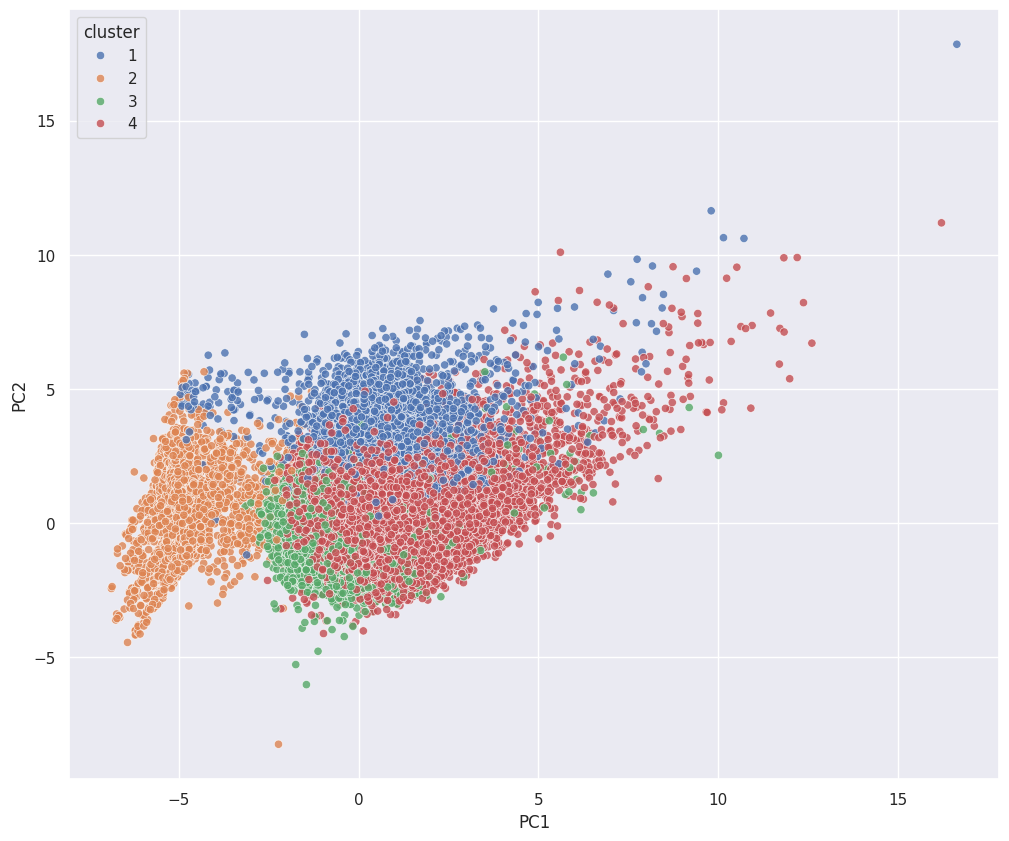

In [ ]:
plt.figure(figsize = (12, 10))
g = sns.scatterplot(data = X_pc, x = 'PC1', y = 'PC2', hue = 'cluster', alpha = 0.8)

* Each dot represents a patient, and depicts the respective position after being "projected" to PC1 and PC2.
* The closer two dots are, the more similar the two patients are data-wise.

---

### 4.1.2. Choosing the number of Clusters

Depending on your dataset and research question, you should experiment with different number of clusters. Typically, 3~6 clusters yield the best results in terms of interpretation and clinical understanding.

The simplest way to determine the number of clusters is called the **"Elbow method"** which involves plotting a graph of within-cluster distance against number of clusters. Within-cluster distance is a measure of dispersion of data points within the same cluster, and it decreases with the number of clusters. Intuitively, we may imagine that the plot resembles an arm. Of which the "elbow" (the point of inflection on the curve) indicates a reasonable choice of number of clusters.

![Elbow Method](https://www.oreilly.com/api/v2/epubs/9781788295758/files/assets/995b8b58-06f1-4884-a2a1-f3648428e947.png)

([Source](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml))

In [ ]:
# run KMeans once from 2 clusters to 12. Extract the distance for each and add it to `ssd_list`
ssd_list = []
n_cluster_list = range(2, 13)
for n_cluster in n_cluster_list:
    model_kmeans_tmp = KMeans(n_clusters=n_cluster, n_init='auto')
    model_kmeans_tmp.fit(X_pc)
    ssd_list.append(model_kmeans_tmp.inertia_)

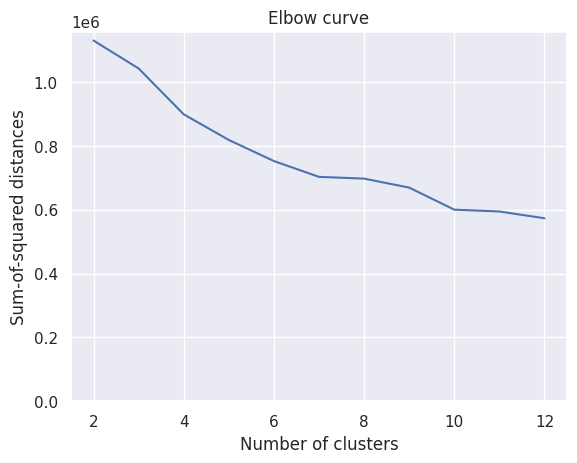

In [ ]:
g = sns.lineplot(x = n_cluster_list, y = ssd_list)
g.set(
    title = 'Elbow curve',
    xlabel = 'Number of clusters',
    ylabel = 'Sum-of-squared distances',
    ylim = (0, None)
)
plt.show()

* As there isn't an obvious "elbow" point in this case, 4 clusters could be a reasonable choice here to faciliate understanding.

---

## 4.2. Understanding the Clusters

### 4.2.1. Intuition

To understand the characteristics of each cluster, we can start off by comparing the scatter plot above with the "driving forces" of PC1 and PC2. Although this isn't necessary, this helps us gain some intuition about how item loadings relate to patient characteristics. Here, we plot the 5-most influential item loadings of the two PCs on the same axes.

In [ ]:
# the longer the arrows are, the more influential the feature is to the values of PC1 and 2.
tmp_df = df_pca_loadings[['PC1', 'PC2']].copy()
tmp_df['distance'] = np.sqrt(np.square(tmp_df['PC1']) + np.square(tmp_df['PC2'])) # distance formula
tmp_df = tmp_df.sort_values(by = 'distance', key = lambda value: abs(value), ascending = False)
tmp_df['rank'] = tmp_df.reset_index().index + 1
tmp_df.head()

,PC1,PC2,distance,rank
Feature,,,,
AGE,0.820215,-0.250250,0.857541,1
ADMISSION_TYPE_NEWBORN,-0.846813,0.091838,0.851778,2
MARITAL_STATUS_UNKNOWN (DEFAULT),-0.755919,0.153362,0.771320,3
PRES_COUNT_DAY,0.664652,0.269782,0.717318,4
LAB_COUNT_DAY,0.644130,0.265195,0.696586,5


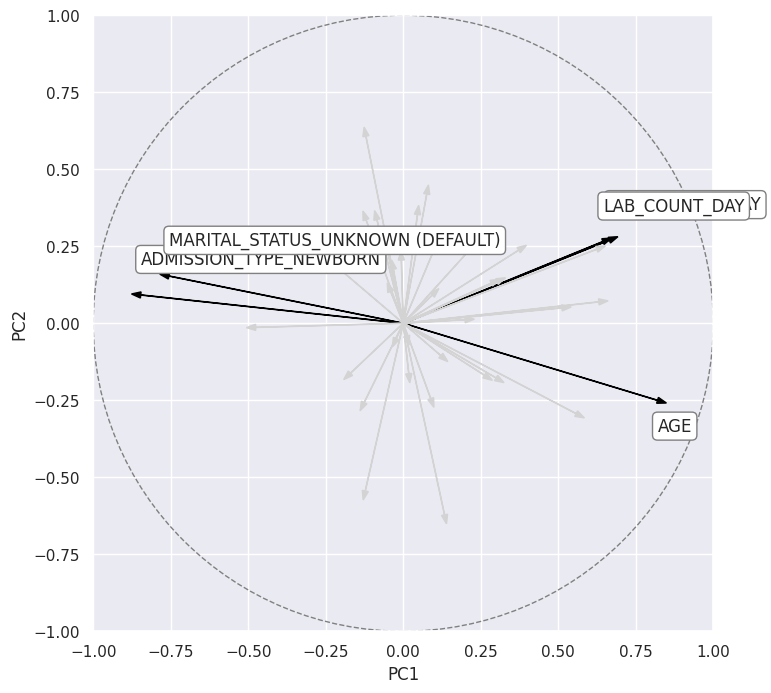

In [ ]:
# unfortunately, the plot below is slightly more complex and cannot be plotted using purely seaborn functions (e.g. `sns.lineplot`). We use `plt.annotate` instead.
plt.figure(figsize = (8, 8)) \
  .add_subplot().add_patch(plt.Circle((0, 0), radius=1, edgecolor='gray', ls='--', fc='None')) # plot a circle
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')

# loop through the rows above and draw an arrow for each.
for index, row in tmp_df.iterrows():
  if row['rank'] > 5:
    # draw a grey arrow if it's less important
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='lightgrey', head_width=0.02)
  else:
    # draw a labelled black arrow if it's one of the most influential factors
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='black', head_width=0.02)
    plt.annotate(index, xy=(0,0), xytext=(row['PC1'], row['PC2'] + np.sign(row['PC2'])*0.1),
        bbox=dict(boxstyle="round", fc="white", ec="gray")
    )

* The most influential factor is `AGE`.
* A patient with high `AGE` is essentially dragged towards the direction the arrow points to. If we also take the previous scatter plot above into consideration, we know the values of PC1 of cluster 2 patients are relatively low. we can speculate that cluster 2 patients have a relatively low `AGE`.


Next, we evaluate the clusters by **comparing** the feature values of each cluster **graphically** and **statistically**. Exploratory data analysis techniques previously covered in class can also be applied here.

In [ ]:
# make a DataFrame that combines all info: features, PCs and cluster
df_clustered = pd.concat([df, X_pc], axis = 1)
df_clustered.head(5)

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cluster
0,3115,134067,EMERGENCY,2139-02-13 03:11:00,2139-02-20 07:33:00,NaN,STAB WOUND,UNKNOWN (DEFAULT),Medicare,ENGL,...,-0.566442,0.281063,1.363703,0.384929,0.569528,0.189411,0.284689,-0.437574,2.373976,4
1,7124,109129,EMERGENCY,2188-07-11 00:58:00,2188-08-01 12:04:00,NaN,PENILE LACERATION-CELLULITIS,UNKNOWN (DEFAULT),Medicare,ENGL,...,-1.081355,1.301904,0.758308,0.823133,-0.328148,0.194201,0.636607,-0.263755,1.423699,4
2,10348,121510,EMERGENCY,2133-04-16 21:12:00,2133-04-23 15:52:00,NaN,STATUS EPILEPTICUS,UNKNOWN (DEFAULT),Medicare,ENGL,...,-0.048181,1.126890,-0.393895,0.381693,2.262392,-0.368178,-0.801795,-1.920845,0.638892,4
3,9396,106469,EMERGENCY,2109-02-16 23:14:00,2109-02-23 12:01:00,NaN,SUBDURAL HEMATOMA,UNKNOWN (DEFAULT),Medicare,ENGL,...,-1.196197,0.581449,-0.792482,0.229536,0.109706,0.041214,0.368488,-0.650011,1.425386,4
4,9333,133732,URGENT,2167-10-06 18:35:00,2167-10-16 13:13:00,NaN,CORONARY ARTERY DISEASE,UNKNOWN (DEFAULT),Private,ENGL,...,0.099474,0.548569,2.300060,-0.921387,2.435926,-1.277195,-2.647747,-1.423151,1.342927,3


We can calculate some descriptive statistics by group/cluster. You can also apply statistical tests such as t-tests to compare whether there is a significant difference between groups.

In the following sections, we highlight some distinctive features based on the top item loadings above.

If you simply want a summary table that includes all variables, run the following line:

In [ ]:
with pd.option_context('display.max_rows', 200):
  display(df_clustered[features_list + ['cluster']].groupby('cluster').agg(['mean', 'std']).T)

cluster                                        1          2          3  \
GENDER_F                         mean   0.441772   0.459880   0.415247   
                                 std    0.496653   0.498418   0.492794   
AGE                              mean  65.285237   0.749479  63.235497   
                                 std   19.460025   5.623953  14.271139   
LOS                              mean  10.738257  11.578860   9.321723   
                                 std   12.253431  20.180081  10.296394   
LOS_ICU                          mean   4.645457   9.833390   3.686571   
                                 std    7.542425  20.603890   6.581305   
CALLOUT_COUNT_DAY                mean   0.115931   0.000619   0.089525   
                                 std    0.143536   0.011331   0.120108   
PRES_COUNT_DAY                   mean   9.864680   0.718947  10.040524   
                                 std    7.212727   1.621694   6.798484   
PROC_COUNT_DAY                   mean   0.581552   0.442121   0.704295   
                                 std    0.745370   0.497611   0.677666   
CPT_COUNT_DAY                    mean   1.211188   0.015545   0.632119   
                                 std    0.913121   0.096124   0.723570   
LAB_COUNT_DAY                    mean  45.239716   9.855153  39.431687   
                                 std   30.055064  11.082259  23.080912   
INPUTS_CV_COUNT_DAY              mean  21.980180  11.448601  25.172793   
                                 std   47.473678  20.847557  45.924716   
INPUTS_MV_COUNT_DAY              mean   7.372907   0.023234   6.014043   
                                 std   17.683238   0.560799  11.742846   
OUTPUT_COUNT_DAY                 mean   7.543107   0.891877   9.183348   
                                 std    6.610256   1.653264   6.768497   
TRANSFER_COUNT_DAY               mean   0.758178   1.154694   0.872272   
                                 std    0.607191   0.838114   0.623707   
MICRO_COUNT_DAY                  mean   1.334172   0.272421   0.560860   
                                 std    2.193108   0.427723   1.001492   
ADMISSION_TYPE_ELECTIVE          mean   0.108884   0.001225   0.858011   
                                 std    0.311529   0.034981   0.349060   
ADMISSION_TYPE_EMERGENCY         mean   0.856602   0.041039   0.000357   
                                 std    0.350517   0.198392   0.018902   
ADMISSION_TYPE_NEWBORN           mean   0.016923   0.953939   0.000000   
                                 std    0.128996   0.209631   0.000000   
ADMISSION_TYPE_URGENT            mean   0.017591   0.003798   0.141632   
                                 std    0.131473   0.061512   0.348693   
RELIGION_CATHOLIC                mean   0.310399   0.256156   0.428946   
                                 std    0.462708   0.436536   0.494955   
RELIGION_NOT SPECIFIED           mean   0.239813   0.177631   0.204765   
                                 std    0.427017   0.382225   0.403554   
RELIGION_UNOBTAINABLE            mean   0.133601   0.355507   0.065753   
                                 std    0.340261   0.478696   0.247865   
RELIGION_OTHERS                  mean   0.316188   0.210707   0.300536   
                                 std    0.465039   0.407836   0.458518   
INSURANCE_Medicare               mean   0.560009   0.000368   0.511614   
                                 std    0.496441   0.019168   0.499895   
INSURANCE_Private                mean   0.153863   0.795908   0.426444   
                                 std    0.360858   0.403061   0.494589   
INSURANCE_Medicaid               mean   0.192830   0.149945   0.045027   
                                 std    0.394565   0.357039   0.207375   
INSURANCE_OTHERS                 mean   0.093298   0.053779   0.016915   
                                 std    0.290882   0.225595   0.128960   
MARITAL_STATUS_MARRIED           mean   0.505455   0.000490   0.604765   
    

### 4.2.1. Features related to Age

An easy way to compare basic statistics per cluster is to use `.describe()` after `.groupby()`.

In [ ]:
df_clustered[['AGE', 'ADMISSION_TYPE_NEWBORN', 'cluster']].groupby('cluster').describe()

AGE                                                     \
           count       mean        std  min   25%   50%   75%   max   
cluster                                                               
1         4491.0  65.285237  19.460025  0.0  54.0  69.0  80.0  90.0   
2         8163.0   0.749479   5.623953  0.0   0.0   0.0   0.0  90.0   
3         8395.0  63.235497  14.271139  0.0  54.0  64.0  74.0  90.0   
4        37927.0  63.197036  17.872820  0.0  51.0  65.0  78.0  90.0   

        ADMISSION_TYPE_NEWBORN                                               
                         count      mean       std  min  25%  50%  75%  max  
cluster                                                                      
1                       4491.0  0.016923  0.128996  0.0  0.0  0.0  0.0  1.0  
2                       8163.0  0.953939  0.209631  0.0  1.0  1.0  1.0  1.0  
3                       8395.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
4                      37927.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

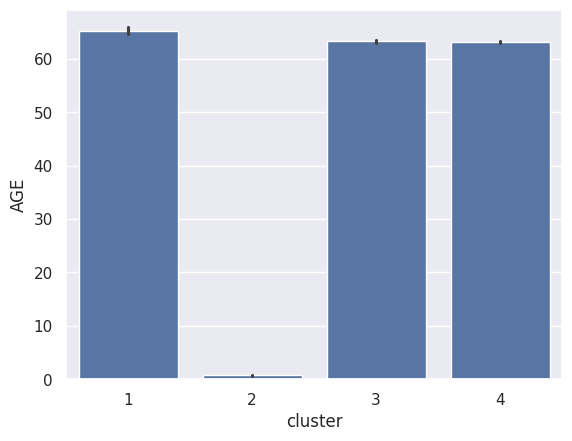

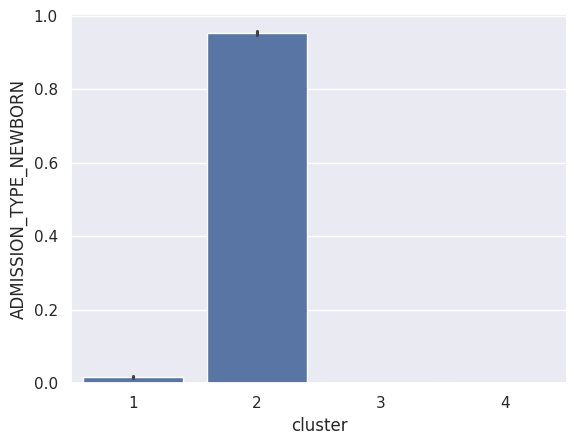

In [ ]:
# graphical comparison
for col_name in ['AGE', 'ADMISSION_TYPE_NEWBORN']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 2 patients are much younger and `ADMISSION_TYPE_NEWBORN` is much more likely to be 1 (**infants**).
* The difference in `AGE` for the other groups may not be significant visually. Further statistical analysis is needed to draw conclusions.

For statistical tests, we can begin by conducting a one-way ANOVA F-test for overall difference and then Tukey's HSD post-hoc test for pairwise difference. Using `AGE` as an example here:

In [ ]:
# specify the independent and dependent variables in our test
# The general structure for entering the equation is "dependent_variable ~ C(independent_variable)"
model_ols = ols(formula='AGE ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2.761282e+07,9.204274e+06,34390.981659,0.0
Residual,58972.0,1.578305e+07,2.676363e+02,NaN,NaN


In [ ]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['AGE'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -64.5358    0.0 -65.3166 -63.7549   True
     1      3  -2.0497    0.0  -2.8268  -1.2727   True
     1      4  -2.0882    0.0  -2.7515  -1.4249   True
     2      3   62.486    0.0  61.8327  63.1393   True
     2      4  62.4476    0.0  61.9347  62.9604   True
     3      4  -0.0385 0.9974  -0.5454   0.4685  False
------------------------------------------------------


* Unsurprisingly, there is a statistically significant difference between the clusters in terms of `AGE` overall (F-statistic ~= 34,391, p-value < 0.05).
* The 4 clusters differed significantly from each other in terms of `AGE`, except between clusters 3 and 4.

### 4.2.2. Features related to Event Counts

In [ ]:
df_clustered[['PROC_COUNT_DAY', 'LAB_COUNT_DAY', 'cluster']].groupby('cluster').describe()

PROC_COUNT_DAY                                                         \
                 count      mean       std  min       25%       50%       75%   
cluster                                                                         
1               4491.0  0.581552  0.745370  0.0  0.196197  0.392894  0.684248   
2               8163.0  0.442121  0.497611  0.0  0.187225  0.377688  0.523066   
3               8395.0  0.704295  0.677666  0.0  0.369610  0.564672  0.823619   
4              37927.0  0.610178  0.847795  0.0  0.186717  0.393819  0.717846   

                   LAB_COUNT_DAY                                        \
               max         count       mean        std  min        25%   
cluster                                                                  
1         9.158513        4491.0  45.239716  30.055064  0.0  31.454904   
2        11.000000        8163.0   9.855153  11.082259  0.0   3.645831   
3        14.000000        8395.0  39.431687  23.080912  0.0  28.779495   
4        20.000000       37927.0  48.074234  30.302368  0.0  32.837778   

                                           
               50%        75%         max  
cluster                                    
1        40.229885  51.381056  626.054667  
2         7.837079  12.687553  169.000000  
3        37.831669  47.133652  502.633698  
4        41.766691  54.213157  507.000000

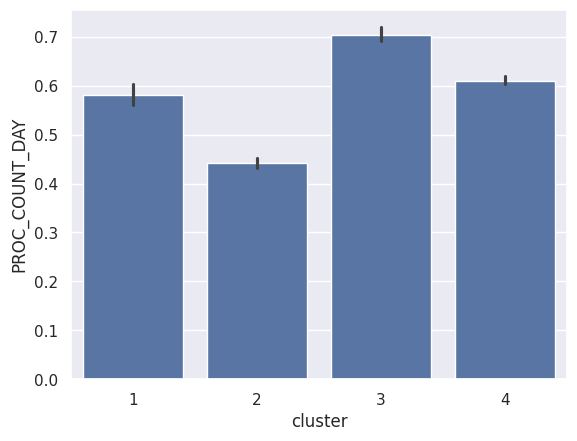

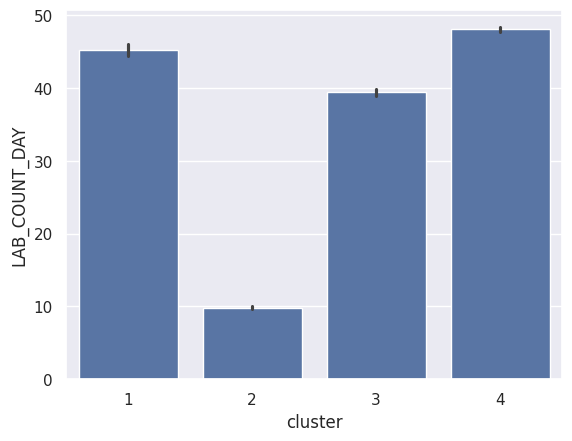

In [ ]:
for col_name in ['PROC_COUNT_DAY', 'LAB_COUNT_DAY']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 2 had the lowest `LAB_COUNT_DAY` and `PROC_COUNT_DAY`.
* Among the 3 remaining groups, Cluster 3 patients had a lower `LAB_COUNT_DAY` but higher `PROC_COUNT_DAY`.

In [ ]:
# specify the independent and dependent variables in our test.
model_ols = ols(formula='LAB_COUNT_DAY ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,9.910802e+06,3.303601e+06,4392.295621,0.0
Residual,58972.0,4.435492e+07,7.521353e+02,NaN,NaN


In [ ]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['LAB_COUNT_DAY'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     1      2 -35.3846   0.0 -36.6936 -34.0755   True
     1      3   -5.808   0.0  -7.1106  -4.5054   True
     1      4   2.8345   0.0   1.7226   3.9464   True
     2      3  29.5765   0.0  28.4813  30.6717   True
     2      4  38.2191   0.0  37.3594  39.0788   True
     3      4   8.6425   0.0   7.7927   9.4924   True
-----------------------------------------------------


* From our ANOVA F-test, there is a statistically significant difference between the clusters in terms of `LAB_COUNT_DAY` (F-statistic ~= 4,392, p-value < 0.05).
* In addition, based on Tukey's HSD, all 4 clusters differed significantly in terms of `LAB_COUNT_DAY` (even between cluster 1 and cluster 4 patients, which looked the closest in the bar chart).

### 4.2.3. Features related to LOS

In [ ]:
df_clustered[['LOS', 'LOS_ICU', 'cluster']].groupby('cluster').describe()

LOS                                                            \
           count       mean        std  min       25%       50%        75%   
cluster                                                                      
1         4491.0  10.738257  12.253431  1.0  4.087847  7.113194  12.795139   
2         8163.0  11.578860  20.180081  1.0  2.321875  4.084028   9.909028   
3         8395.0   9.321723  10.296394  1.0  4.338889  6.395833  10.252778   
4        37927.0   9.960766  10.544035  1.0  3.832292  6.893056  12.087153   

                     LOS_ICU                                            \
                max    count      mean        std  min     25%     50%   
cluster                                                                  
1        169.159722   4491.0  4.645457   7.542425  0.0  1.2162  2.2066   
2        294.660417   8163.0  9.833390  20.603890  0.0  0.1375  0.7951   
3        191.422917   8395.0  3.686571   6.581305  0.0  1.0811  1.9433   
4        206.425694  37927.0  4.495003   6.583411  0.0  1.2360  2.2453   

                            
             75%       max  
cluster                     
1        4.75760  169.4202  
2        9.17020  260.7089  
3        3.42900  142.0258  
4        4.73135  153.9280

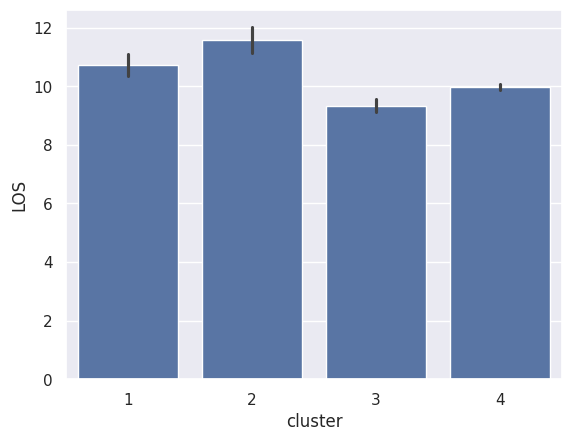

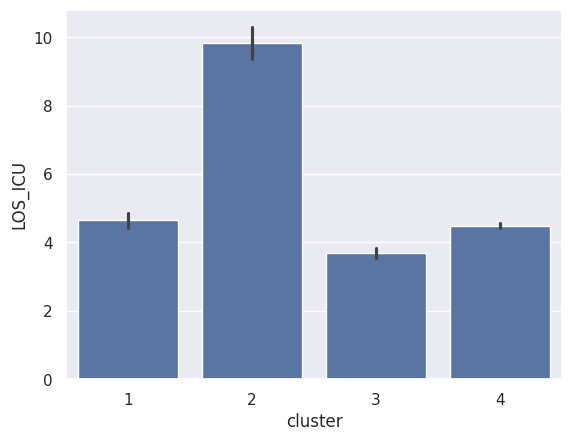

In [ ]:
for col_name in ['LOS', 'LOS_ICU']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 2 patients had a longer LOS and LOS in ICU.

In [ ]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='LOS ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2.533697e+04,8445.657814,54.705134,2.653558e-35
Residual,58972.0,9.104398e+06,154.385103,NaN,NaN


In [ ]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['LOS'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.8406 0.0015  0.2475  1.4337   True
     1      3  -1.4165    0.0 -2.0067 -0.8264   True
     1      4  -0.7775 0.0004 -1.2812 -0.2737   True
     2      3  -2.2571    0.0 -2.7533 -1.7609   True
     2      4  -1.6181    0.0 -2.0076 -1.2286   True
     3      4    0.639 0.0001   0.254  1.0241   True
----------------------------------------------------


* While the bar chart for `LOS` may look close, it is significantly different across all clusters, including pairwise comparison.

### 4.2.4. Categorical Features

As for categorical features such as `ETHNICITY` and `LANGUAGE`, it is best to compute the distribution of category per cluster instead.

In [ ]:
# calculate the % distribution of ethnicity per cluster
tmp_df_ethnicity = df_clustered[['ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS', 'cluster']].groupby('cluster').mean()
tmp_df_ethnicity

,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
cluster,,,,
1,0.338009,0.034513,0.061902,0.565576
2,0.605047,0.109641,0.065172,0.220140
3,0.765932,0.043121,0.107921,0.083026
4,0.741134,0.106204,0.074011,0.078651


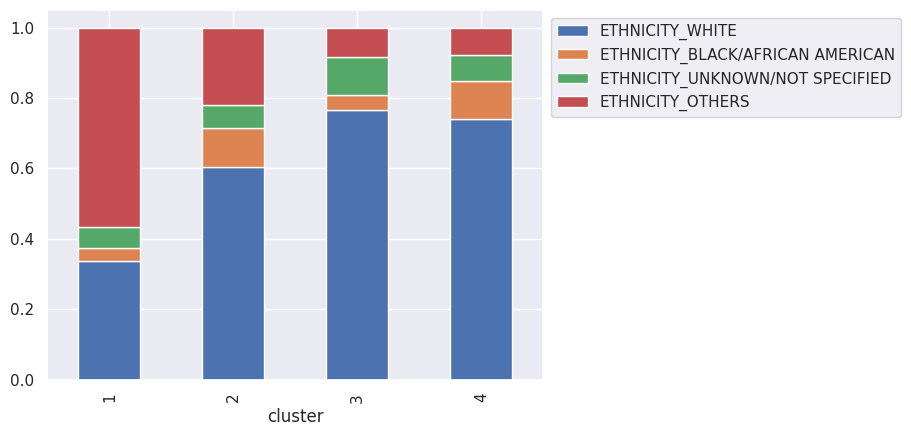

In [ ]:
tmp_df_ethnicity.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") # move legend so that it won't cover the main graph

In [ ]:
tmp_df_language = df_clustered[['LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS', 'cluster']].groupby('cluster').mean()
tmp_df_language

,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS
cluster,,,,
1,0.000000,0.240258,0.175462,0.584280
2,0.991792,0.000490,0.000245,0.007473
3,1.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000


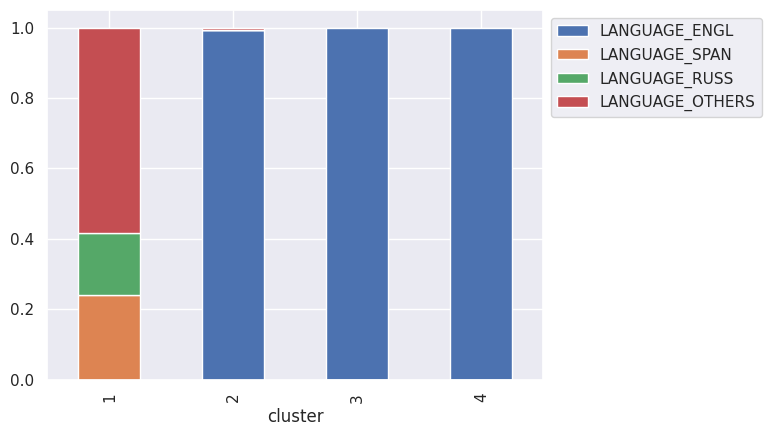

In [ ]:
tmp_df_language.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") # move legend so that it won't cover the main graph

* Cluster 1 is primarily comprised of **non-english speakers**. They are also less likely to be white.

In [ ]:
tmp_df_maritalstatus = df_clustered[['MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS', 'cluster']].groupby('cluster').mean()
tmp_df_maritalstatus

,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS
cluster,,,,
1,0.505455,0.216656,0.067468,0.210421
2,0.000490,0.035526,0.963861,0.000123
3,0.604765,0.180584,0.026921,0.187731
4,0.445276,0.276188,0.054737,0.223798


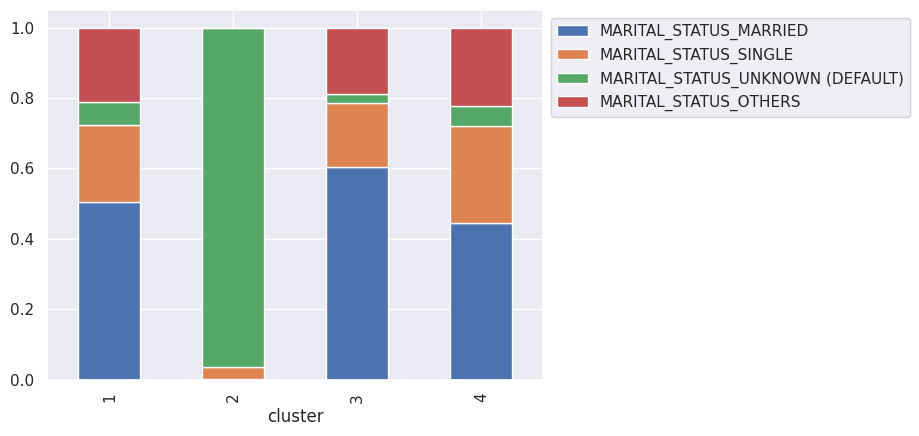

In [ ]:
tmp_df_maritalstatus.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") # move legend so that it won't cover the main graph

For statistically tests, we may use Chi-square test of independence of variables in a contingency table. The following line outputs the Chi-square test statistic and p-value respectively, showing that ethnicity is significantly different across groups as p-value < 0.05.

In [ ]:
chi2_contingency(tmp_df_ethnicity.sum())[:2]

(0.0, 1.0)

In [ ]:
tmp_df_admissiontype = df_clustered[['ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN',
       'ADMISSION_TYPE_URGENT', 'cluster']].groupby('cluster').mean()
tmp_df_admissiontype

,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT
cluster,,,,
1,0.108884,0.856602,0.016923,0.017591
2,0.001225,0.041039,0.953939,0.003798
3,0.858011,0.000357,0.000000,0.141632
4,0.000105,0.998919,0.000000,0.000976


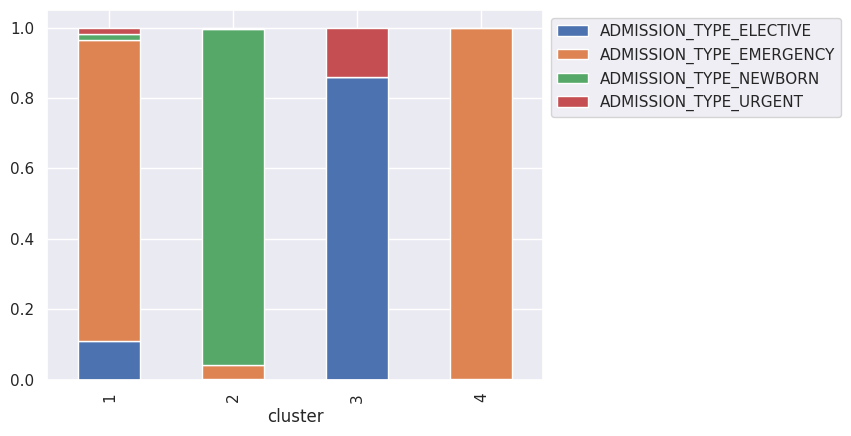

In [ ]:
tmp_df_admissiontype.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") # move legend so that it won't cover the main graph

* One distinction between cluster 3 and 4 patients is **admission type**: cluster 4 patients are predominantly admitted as an emergency.

### 4.2.5. External Features

Associating clusters with other variables that were NOT used for clustering could also provide some interesting insights. In this case, `IN_HOSP_DEATH` was not used in clustering but the mortality rates across clusters are found to be quite different.

In [ ]:
df_clustered[['IN_HOSP_DEATH', 'cluster']].groupby('cluster').describe()

IN_HOSP_DEATH                                             
                count      mean       std  min  25%  50%  75%  max
cluster                                                           
1              4491.0  0.119127  0.323974  0.0  0.0  0.0  0.0  1.0
2              8163.0  0.010290  0.100924  0.0  0.0  0.0  0.0  1.0
3              8395.0  0.037999  0.191205  0.0  0.0  0.0  0.0  1.0
4             37927.0  0.129617  0.335886  0.0  0.0  0.0  0.0  1.0

<Axes: xlabel='cluster', ylabel='IN_HOSP_DEATH'>

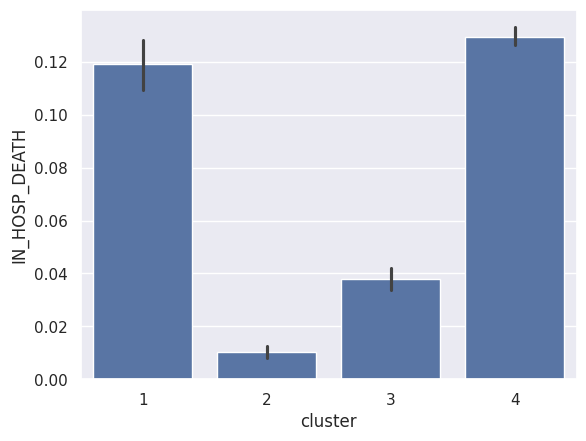

In [ ]:
sns.barplot(data = df_clustered, x = 'cluster', y = 'IN_HOSP_DEATH')

In [ ]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='IN_HOSP_DEATH ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,132.846048,44.282016,508.046213,0.0
Residual,58972.0,5140.081719,0.087161,NaN,NaN


In [ ]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['IN_HOSP_DEATH'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.1088    0.0 -0.1229 -0.0947   True
     1      3  -0.0811    0.0 -0.0952 -0.0671   True
     1      4   0.0105 0.1096 -0.0015  0.0225  False
     2      3   0.0277    0.0  0.0159  0.0395   True
     2      4   0.1193    0.0  0.1101  0.1286   True
     3      4   0.0916    0.0  0.0825  0.1008   True
----------------------------------------------------


* Cluster 1 and 4 patients had a remarkably higher mortality rate, and is significantly higher than the other groups.
* In contrast, Cluster 2 patients had a much lower mortality rate.

---

## 4.3. Conclusions

From all the results presented, we uncovered 4 types of patients within the data, and are able to deduce the key characteristics for each patient group as follows:

Cluster/Patient Group | Key characteristics
---|---
1 | Non-english speakers
2 | Newborn
3 | Non-newborn English speakers who were admitted as elective or urgent
4 | Non-newborn English speakers who were admitted as emergency

<br>

Note that even *without* using `IN_HOSP_DEATH` as one of the input variables in PCA and K-means clustering, the 4 patient groups demonstrated drastically different levels of in-hospital mortality. Specifically, in-hospital mortality rate is higher among Cluster 1 and 4 patients.

From this point, one can extend this cluster analysis by, for example,

* building a predictive model using clusters as an additional feature
* exploring the association between clusters and certain clinical outcomes

---

# Exercise

Using PCA and K-means clustering, explore the type of countries within [COVID-19 worldwide dataset](https://github.com/owid/covid-19-data/blob/master/public/data/) by comparing the latest per-capita statistics up until Mar 01, 2022. Deduce the characteristics of the extracted PCs and clusters.

Here are some pre-processing codes to help you get started. Note that your results may not be exactly the same as the dataset is constantly being updated.

In [ ]:
df_covid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [ ]:
df_covid_filtered = df_covid[df_covid['date'] <= '2022-03-01'] # filter by date
df_covid_filtered = df_covid_filtered[~df_covid_filtered['iso_code'].str.startswith('OWID_')] # removes non-country locations such as "Worldwide", "Asia" and "Low income"

# list of features we will be using for this exercise
features_list_covid = [
  'total_cases_per_million', 'new_cases_smoothed_per_million',
  'total_deaths_per_million', 'new_deaths_smoothed_per_million',
  'total_tests_per_thousand', 'new_tests_smoothed_per_thousand',
  'positive_rate',
  'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
  'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
  'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed_per_hundred',
  'stringency_index', 'human_development_index', 'gdp_per_capita']

len(features_list_covid)

16

In [ ]:
df_covid_filtered = df_covid_filtered[features_list_covid + ['location']].groupby('location').last() # Obtain the latest figure if missing on Mar 01, 2022
df_covid_filtered = df_covid_filtered.dropna() # exclude countries with incomplete data
df_covid_filtered

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,human_development_index,gdp_per_capita
location,,,,,,,,,,,,,,,,
Albania,95455.188,70.868,1217.316,1.357,556.527,0.093,0.6722,95.29,44.71,42.18,8.41,978.0,0.019,46.30,0.795,11803.431
Angola,2773.357,0.337,53.359,0.000,41.271,0.054,0.0058,45.69,29.76,15.31,0.39,1312.0,0.067,64.32,0.581,5819.495
Argentina,195546.026,201.559,2813.230,0.700,764.734,0.655,0.0860,207.58,89.76,74.21,37.92,2482.0,0.026,26.58,0.845,18933.907
Australia,115245.664,875.357,231.192,1.321,2453.345,3.133,0.2771,206.88,84.28,78.28,44.32,3591.0,0.032,35.32,0.944,44648.710
Austria,295361.199,2958.548,1990.018,3.404,17894.548,60.088,0.0497,203.29,76.70,73.90,56.28,624.0,0.007,47.79,0.922,45436.686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,231559.199,193.525,2799.853,5.509,2454.830,2.988,0.0380,169.28,76.58,65.78,30.02,885.0,0.022,37.10,0.926,54225.446
Uruguay,244053.692,1140.838,2030.212,3.965,1666.219,3.000,0.2865,223.78,86.56,80.33,56.89,2110.0,0.017,19.24,0.817,20551.409
Vietnam,33823.315,776.234,408.853,0.936,813.694,1.059,0.9237,198.92,80.85,78.49,39.57,4227.0,0.010,66.67,0.704,6171.884


In [ ]:
df_covid_filtered.describe()

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,human_development_index,gdp_per_capita
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,147027.369413,719.398576,1531.761174,2.729065,2228.314130,5.402141,0.191234,147.848043,64.654674,58.290326,27.347609,2056.217391,0.054533,38.316413,0.790293,23285.248685
std,124409.491984,1000.953712,1308.324531,2.798673,4062.243693,14.634897,0.182468,59.155148,19.533127,20.683643,21.168464,2815.097113,0.174496,16.191518,0.116563,18189.247730
min,211.205000,0.000000,4.312000,0.000000,39.469000,0.037000,0.000000,14.430000,12.420000,5.850000,0.140000,39.000000,0.000000,2.780000,0.456000,1136.103000
25%,40011.196000,34.666250,404.315250,0.447250,316.855500,0.619000,0.050075,104.617500,53.737500,45.912500,8.332500,622.000000,0.008000,27.762500,0.718000,8579.840500
50%,113649.629500,332.922500,1181.541500,1.733500,978.174000,1.777000,0.143250,160.470000,70.735000,63.325000,26.620000,1179.500000,0.018500,38.725000,0.810000,18748.607000
75%,236394.913250,906.753500,2274.574250,4.145000,2153.638250,4.284000,0.263200,198.852500,79.730000,74.462500,46.750000,2485.500000,0.045750,49.875000,0.888500,32737.509500
max,464414.437000,4906.374000,6174.201000,10.759000,28794.487000,118.427000,0.923700,255.740000,104.660000,100.470000,73.480000,21955.000000,1.650000,79.170000,0.957000,94277.965000


In [ ]:
# standardise all input columns
X_covid = pd.DataFrame(StandardScaler().fit_transform(df_covid_filtered), columns=df_covid_filtered.columns, index = df_covid_filtered.index)
X_covid

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,human_development_index,gdp_per_capita
location,,,,,,,,,,,,,,,,
Albania,-0.416807,-0.651463,-0.241659,-0.492942,-0.413798,-0.364761,2.650339,-0.893346,-1.026664,-0.783160,-0.899516,-0.385111,-0.204745,0.495774,0.040599,-0.634701
Angola,-1.165863,-0.722313,-1.136188,-0.980471,-0.541333,-0.367440,-1.021822,-1.736414,-1.796224,-2.089373,-1.280458,-0.265815,0.071839,1.614801,-1.805371,-0.965486
Argentina,0.392129,-0.520181,0.984840,-0.728982,-0.362263,-0.326149,-0.579885,1.015284,1.292312,0.773892,0.502177,0.152078,-0.164410,-0.728821,0.471900,-0.240537
Australia,-0.256860,0.156664,-0.999519,-0.505876,0.055699,-0.155900,0.473162,1.003386,1.010226,0.971744,0.806170,0.548184,-0.129837,-0.186075,1.325876,1.180946
Austria,1.198836,2.249274,0.352182,0.242484,3.877679,3.757150,-0.779914,0.942365,0.620040,0.758822,1.374258,-0.511551,-0.273892,0.588302,1.136104,1.224505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,0.683188,-0.528251,0.974560,0.998747,0.056067,-0.165862,-0.844386,0.364286,0.613863,0.364090,0.126936,-0.418328,-0.187459,-0.075538,1.170608,1.710336
Uruguay,0.784168,0.423345,0.383072,0.444034,-0.139129,-0.165037,0.524960,1.290640,1.127590,1.071399,1.403232,0.019210,-0.216270,-1.184629,0.230371,-0.151123
Vietnam,-0.914917,0.057092,-0.862982,-0.644195,-0.350144,-0.298392,4.036216,0.868087,0.833664,0.981953,0.580551,0.775347,-0.256605,1.760734,-0.744370,-0.946006


In [ ]:
# YOUR CODE HERE #

## Suggested Solution

Note that your results may **not be exactly the same** as the dataset is constantly being updated.

### PCA

#### Training

In [ ]:
# 1. Specify a model to be trained
model_pca_covid = PCA(n_components = 6, random_state = 1)

# 2. Train the model
model_pca_covid.fit(X_covid)

PCA(n_components=6, random_state=1)

In [ ]:
model_pca_covid.explained_variance_ratio_

array([0.38255912, 0.16484501, 0.10930939, 0.09225229, 0.07029265,
       0.05781986])

* Here, I used 6 PCs, but it is also reasonable to set `n_components` to be any number that is at least 4 due to the higher % explained variance. If we retain 4 PCs only, we can still explain more than 70% of the variance.

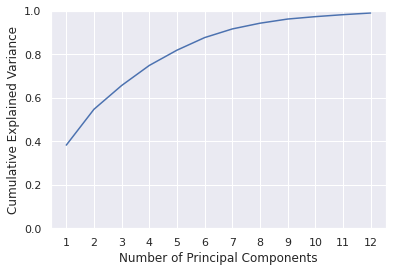

In [ ]:
# train a temporary PCA model with 12 PCs so that we can visualise the relationship between PCs and explained variance better
tmp_model_pca_covid = PCA(n_components = 12, random_state = 1)
tmp_model_pca_covid.fit(X_covid)

g = sns.lineplot(
    x = range(1, 1 + tmp_model_pca_covid.n_components),
    y = np.cumsum(tmp_model_pca_covid.explained_variance_ratio_)
)
g.set(
    xlabel = 'Number of Principal Components',
    ylabel = 'Cumulative Explained Variance',
    xticks = range(1, 1 + tmp_model_pca_covid.n_components),
    ylim = [0, 1]
)
g

#### Item Loadings

In [ ]:
df_pca_loadings_covid = pd.DataFrame(
    data = model_pca_covid.components_.T * np.sqrt(model_pca_covid.explained_variance_) / np.std(X_covid).values.reshape((len(features_list_covid), 1)), # equation to computing item loadings
    index = features_list_covid,  # list of row names
    columns = ['PC' + str(i + 1) for i in range(model_pca_covid.n_components_)] # list of column names
).rename_axis('Feature')

df_pca_loadings_covid

,PC1,PC2,PC3,PC4,PC5,PC6
Feature,,,,,,
total_cases_per_million,0.742745,-0.462575,0.048402,0.140820,-0.143245,-0.169749
new_cases_smoothed_per_million,0.679122,-0.256121,0.202616,0.281742,-0.257668,0.375111
total_deaths_per_million,0.227591,-0.618182,-0.150894,0.325013,0.475331,-0.349151
new_deaths_smoothed_per_million,0.445566,-0.547288,0.117730,0.527394,0.248865,-0.032498
total_tests_per_thousand,0.613465,-0.076048,0.736625,-0.193438,-0.025911,0.003481
new_tests_smoothed_per_thousand,0.467256,0.003586,0.818485,-0.196041,0.036726,0.076995
positive_rate,0.327059,-0.288378,-0.441142,0.250574,-0.349538,0.527645
total_vaccinations_per_hundred,0.841477,0.482740,-0.177269,-0.038957,0.092841,-0.044176
people_vaccinated_per_hundred,0.742604,0.581127,-0.177145,0.027358,0.111771,-0.083436


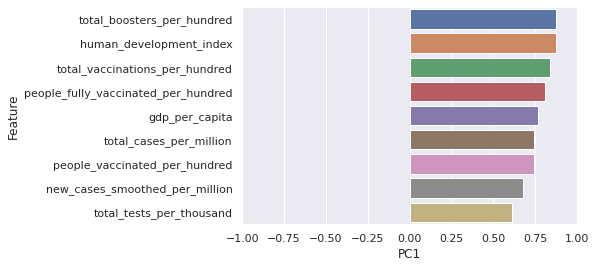

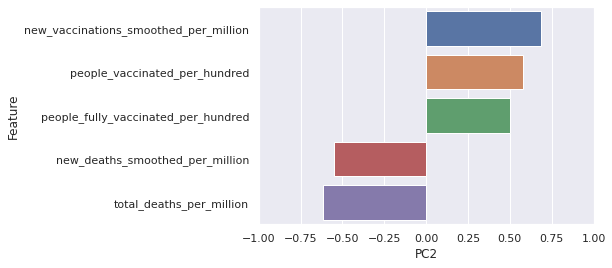

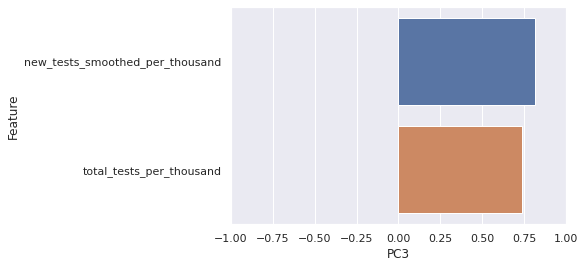

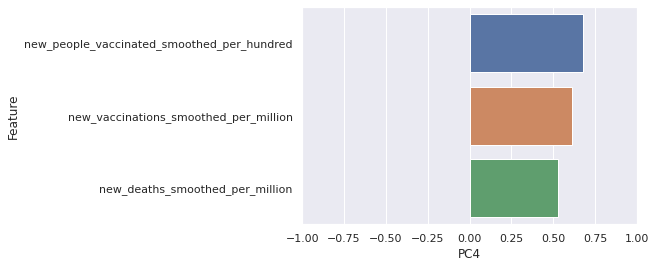

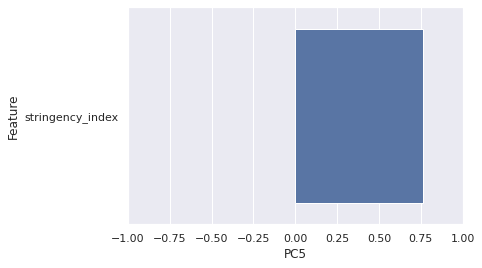

In [ ]:
for col_name in df_pca_loadings_covid.columns[:5]:
  tmp_df = df_pca_loadings_covid[col_name].sort_values(key = lambda value: abs(value), ascending = False) \
    .sort_values(ascending = False)

  tmp_df = tmp_df[abs(tmp_df) > 0.5] # you can adjust this threshold to see more/less features

  # plot it
  g = sns.barplot(x = tmp_df, y = tmp_df.index)
  g.set(xlim = [-1, 1])
  plt.show()
  print()

As such, the key features of each PC is summarised as follows:

PC | Key Features
---|---
1 | Country development, Vaccinations and Cases
2 | Vaccinations and deaths
3 | COVID Tests
4 | New vaccinations and deaths
5 | Strictness of 'lockdown style' policies

### K-means Clustering

#### Choosing the number of Clusters

In [ ]:
X_pc_covid = model_pca_covid.transform(X_covid) # apply the PCA model above to obtain PCs
X_pc_covid = pd.DataFrame(X_pc_covid,
                          index = X_covid.index,
                          columns = ['PC' + str(i + 1) for i in range(model_pca_covid.n_components_)]) # convert it to a table by adding column names

X_pc_covid

,PC1,PC2,PC3,PC4,PC5,PC6
location,,,,,,
Albania,-1.694652,-1.325769,-1.047030,-0.031234,-1.085772,1.612359
Angola,-4.468335,-0.580829,0.875698,-1.111829,-0.134096,0.672170
Argentina,1.006385,0.858058,-0.949866,0.171006,0.695316,-1.469075
Australia,1.879343,1.619596,-0.792244,-0.362375,-0.115738,0.785685
Austria,4.501196,-0.396715,4.422871,-1.200507,0.413793,0.846083
...,...,...,...,...,...,...
United States,1.500717,-0.629590,-0.301566,0.061426,1.735500,-0.718817
Uruguay,1.985288,0.370976,-1.039659,0.323315,-0.716012,-1.060232
Vietnam,0.366649,1.172040,-1.906265,0.515356,-0.641134,3.249841


In [ ]:
# run KMeans once from 2 clusters to 12. Extract the distance for each and add it to `ssd_list`
ssd_list = []
n_cluster_list = range(2, 13)
for n_cluster in n_cluster_list:
    model_kmeans_tmp = KMeans(n_clusters=n_cluster)
    model_kmeans_tmp.fit(X_pc_covid)
    ssd_list.append(model_kmeans_tmp.inertia_)

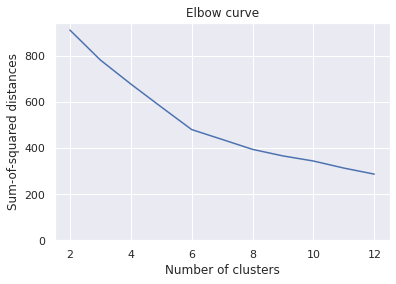

In [ ]:
g = sns.lineplot(x = n_cluster_list, y = ssd_list)
g.set(
    title = 'Elbow curve',
    xlabel = 'Number of clusters',
    ylabel = 'Sum-of-squared distances',
    ylim = (0, None)
)
plt.show()

* 4 is a reasonable choice here. Feel free to choose other numbers of clusters as long as you are able to draw meaningful conclusions from them.

#### Training

In [ ]:
# 1. Specify a model to be trained
model_kmeans_4_covid = KMeans(n_clusters = 4, random_state = 1)

# 2. Train the model
model_kmeans_4_covid.fit(X_pc_covid)

# 3. Extract cluster number
X_pc_covid['cluster'] = model_kmeans_4_covid.predict(X_pc_covid)
X_pc_covid['cluster'] = X_pc_covid['cluster'].map(dict(X_pc_covid['cluster'].value_counts().rank().astype(int))) # rename categories such that 1 is the smallest group and 4 is the largest group
X_pc_covid['cluster'] = pd.Categorical(X_pc_covid['cluster'])
X_pc_covid['cluster']

location
Albania          3
Angola           3
Argentina        4
Australia        4
Austria          1
                ..
United States    4
Uruguay          4
Vietnam          2
Zambia           3
Zimbabwe         3
Name: cluster, Length: 94, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [ ]:
X_pc_covid['cluster'].value_counts()

4    33
3    30
2    27
1     4
Name: cluster, dtype: int64

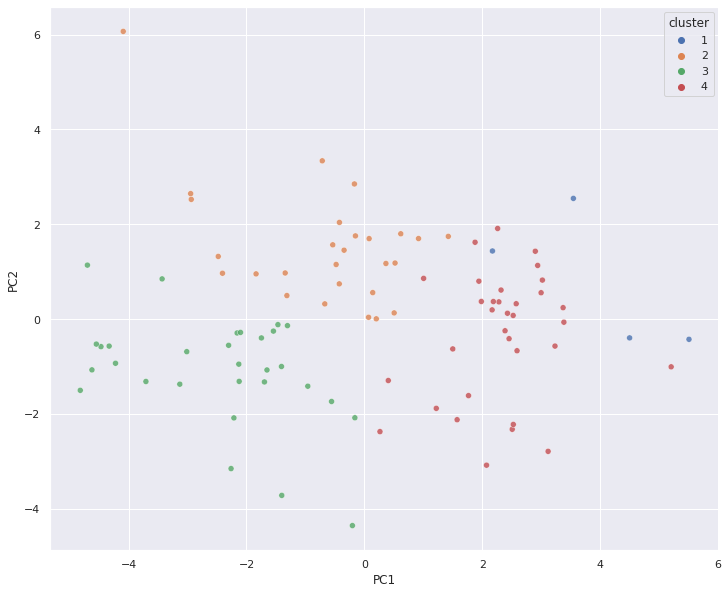

In [ ]:
plt.figure(figsize = (12, 10))
g = sns.scatterplot(data = X_pc_covid, x = 'PC1', y = 'PC2', hue = 'cluster', alpha = 0.8)

In [ ]:
# make a DataFrame that combines all info: features, PCs and cluster
df_clustered_covid = pd.concat([df_covid_filtered, X_pc_covid], axis = 1)
df_clustered_covid

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,...,stringency_index,human_development_index,gdp_per_capita,PC1,PC2,PC3,PC4,PC5,PC6,cluster
location,,,,,,,,,,,,,,,,,,,,,
Albania,94573.004,62.007,1208.521,1.044,552.997,0.092,0.6722,94.28,44.23,41.73,...,46.30,0.795,11803.431,-1.694652,-1.325769,-1.047030,-0.031234,-1.085772,1.612359,3
Angola,2909.976,0.316,55.992,0.004,41.965,0.055,0.0058,47.92,31.21,16.06,...,60.19,0.581,5819.495,-4.468335,-0.580829,0.875698,-1.111829,-0.134096,0.672170,3
Argentina,195242.086,152.086,2768.440,2.002,753.262,0.630,0.0860,205.24,88.48,79.14,...,37.04,0.845,18933.907,1.006385,0.858058,-0.949866,0.171006,0.695316,-1.469075,4
Australia,126289.150,872.619,204.318,1.352,2465.985,3.149,0.2771,210.00,85.56,79.46,...,51.39,0.944,44648.710,1.879343,1.619596,-0.792244,-0.362375,-0.115738,0.785685,4
Austria,299072.041,2978.887,1641.146,3.317,17655.132,59.284,0.0502,199.40,75.21,72.61,...,57.41,0.922,45436.686,4.501196,-0.396715,4.422871,-1.200507,0.413793,0.846083,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,237581.420,186.200,2862.015,5.470,2474.373,2.962,0.0360,167.20,76.52,65.10,...,58.80,0.926,54225.446,1.500717,-0.629590,-0.301566,0.061426,1.735500,-0.718817,4
Uruguay,242284.985,845.054,2005.938,3.525,1638.063,2.949,0.2865,219.25,84.80,78.70,...,20.37,0.817,20551.409,1.985288,0.370976,-1.039659,0.323315,-0.716012,-1.060232,4
Vietnam,36239.905,970.787,410.904,1.334,807.886,1.051,0.9237,198.95,80.86,78.51,...,66.67,0.704,6171.884,0.366649,1.172040,-1.906265,0.515356,-0.641134,3.249841,2


Since we have much fewer dots in the plot, we can even annotate each dot! From this graph you may already tell the difference between clusters.

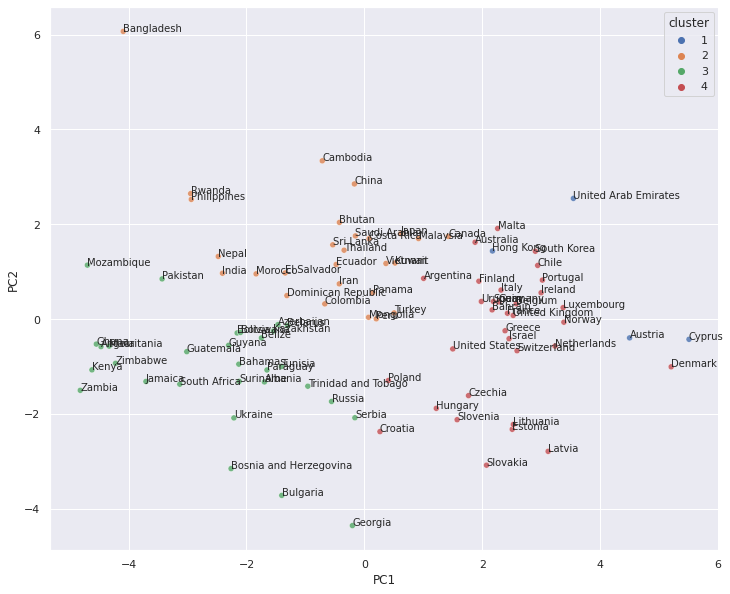

In [ ]:
plt.figure(figsize = (12, 10))
g = sns.scatterplot(data = df_clustered_covid, x = 'PC1', y = 'PC2', hue = 'cluster', alpha = 0.8)

for index, row in df_clustered_covid.iterrows():
  plt.annotate(index, xy=(row['PC1'], row['PC2']), xytext=(row['PC1'], row['PC2']))

### Understanding the Clusters

In [ ]:
# the longer the arrows are, the more influential the feature is in terms of PC1 and 2.
tmp_df = df_pca_loadings_covid[['PC1', 'PC2']].copy()
tmp_df['distance'] = np.sqrt(np.square(tmp_df['PC1']) + np.square(tmp_df['PC2'])) # distance formula
tmp_df = tmp_df.sort_values(by = 'distance', key = lambda value: abs(value), ascending = False)
tmp_df['rank'] = tmp_df.reset_index().index + 1
tmp_df.head()

,PC1,PC2,distance,rank
Feature,,,,
total_vaccinations_per_hundred,0.841477,0.482740,0.970114,1
people_fully_vaccinated_per_hundred,0.808274,0.502466,0.951725,2
people_vaccinated_per_hundred,0.742604,0.581127,0.942957,3
total_boosters_per_hundred,0.876816,0.247411,0.911053,4
human_development_index,0.876262,-0.148825,0.888810,5


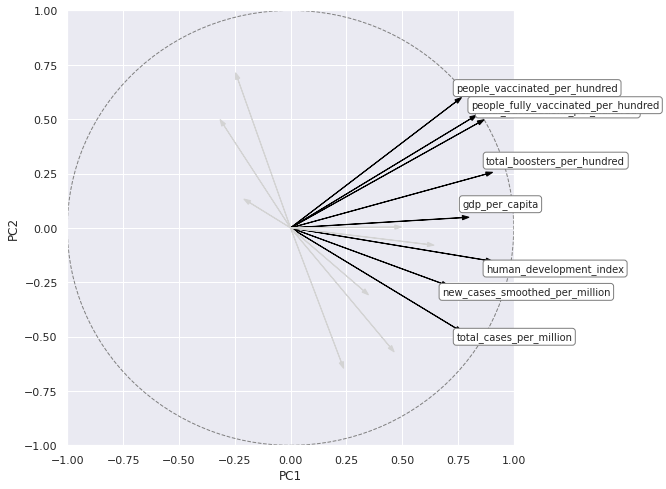

In [ ]:
# unfortunately, the plot below is slightly more complex and cannot be plot using purely seaborn functions (e.g. `sns.lineplot`). We use `plt.annotate` instead.
plt.figure(figsize = (8, 8)) \
  .add_subplot().add_patch(plt.Circle((0, 0), radius=1, edgecolor='gray', ls='--', fc='None')) # plot a circle
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')

# loop through the rows above and draw an arrow for each.
for index, row in tmp_df.iterrows():
  if row['rank'] > 8:
    # draw a grey arrow if it's less important
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='lightgrey', head_width=0.02)
  else:
    # draw a labelled black arrow if it's one of the most influential factors
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='black', head_width=0.02)
    plt.annotate(index, xy=(0,0), xytext=(row['PC1'], row['PC2'] + np.sign(row['PC2'])*0.05),
        bbox=dict(boxstyle="round", fc="white", ec="gray")
    )

#### Vaccinations

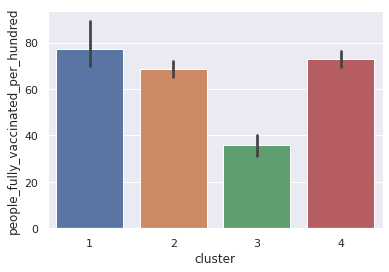

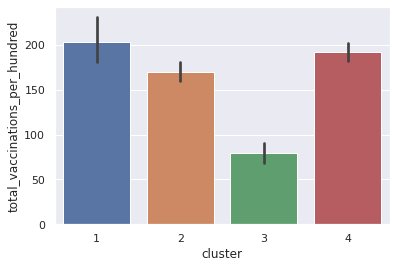

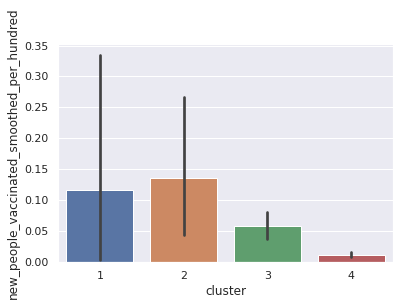

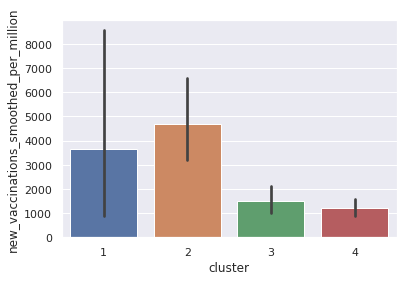

In [ ]:
for col_name in ['people_fully_vaccinated_per_hundred', 'total_vaccinations_per_hundred', 'new_people_vaccinated_smoothed_per_hundred', 'new_vaccinations_smoothed_per_million']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* Cluster 1 and 4 countries have the most vaccination coverage so far while cluster 3 countries have the least.
* Cluster 2 countries are catching up with the most new vaccinations.

#### Deaths

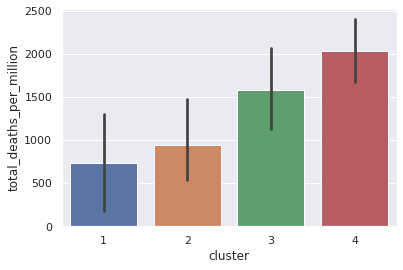

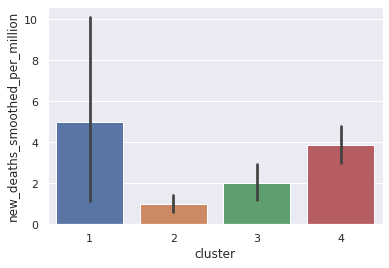

In [ ]:
for col_name in ['total_deaths_per_million', 'new_deaths_smoothed_per_million']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* Note that the error bars of these two figures are particularly large, meaning that the number of total and new deaths vary a lot even for countries within the same cluster. We can conduct statistical tests to see if they are significantly different.

In [ ]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='total_deaths_per_million ~ C(cluster)', data=df_clustered_covid).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2.024067e+07,6.746889e+06,4.488407,0.005543
Residual,90.0,1.352863e+08,1.503181e+06,NaN,NaN


In [ ]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered_covid['total_deaths_per_million'], groups=df_clustered_covid['cluster'])
print(tmp_tukeyhsd)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
     1      2  204.0731    0.9 -1515.4661 1923.6123  False
     1      3  839.2473 0.5657  -869.1621 2547.6566  False
     1      4 1294.8162 0.1977  -404.4328 2994.0651  False
     2      3  635.1742 0.2138  -216.2344 1486.5828  False
     2      4 1090.7431  0.005    257.868 1923.6182   True
     3      4  455.5689 0.4592  -354.0782 1265.2161  False
----------------------------------------------------------


In [ ]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='new_deaths_smoothed_per_million ~ C(cluster)', data=df_clustered_covid).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,156.300987,52.100329,8.906255,0.000031
Residual,90.0,526.487238,5.849858,NaN,NaN


* We deduce that there is significant difference in total deaths (p < 0.001) and new deaths (p < 0.001) between groups.
  * Cluster 1 countries have the lowest number of total death but highest number of new deaths (although not statistically significant).

#### Cases

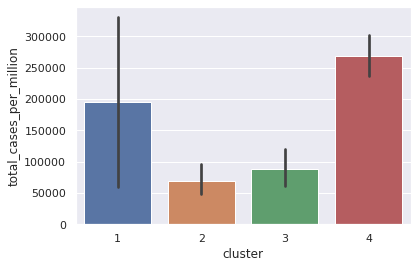

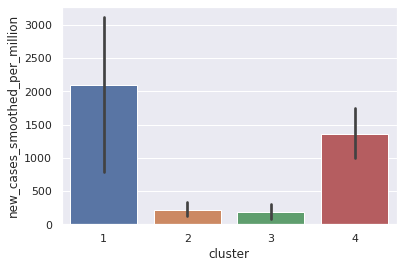

In [ ]:
for col_name in ['total_cases_per_million', 'new_cases_smoothed_per_million']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* Cluster 1 countries have the most new cases.
* Cluster 4 countries have the most total cases.

#### COVID Tests

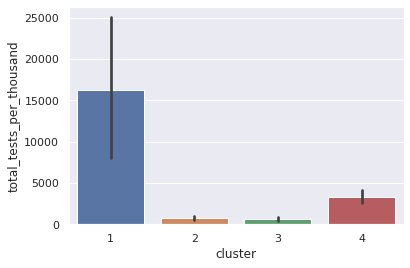

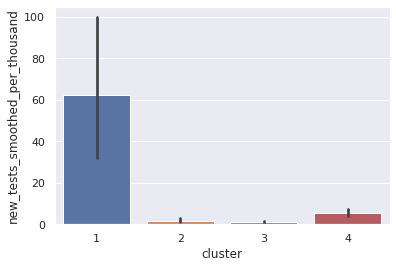

In [ ]:
for col_name in ['total_tests_per_thousand', 'new_tests_smoothed_per_thousand']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* A key distinction between Cluster 1 countries and other countries is the number of COVID tests being carried out.

#### Country Development and Policy

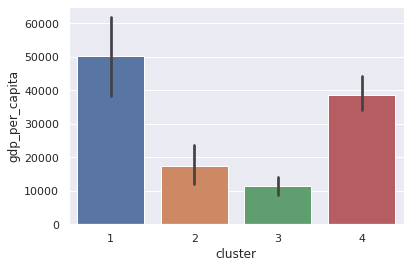

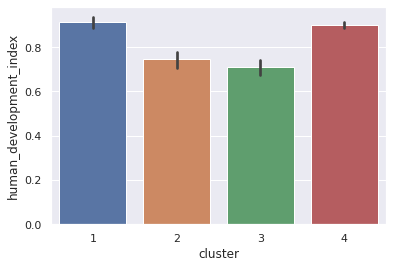

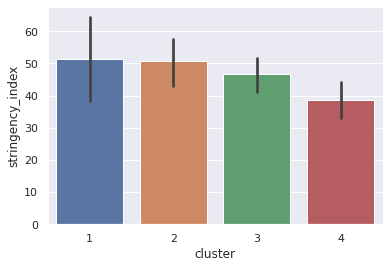

In [ ]:
for col_name in ['gdp_per_capita', 'human_development_index', 'stringency_index']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

In [ ]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='stringency_index ~ C(cluster)', data=df_clustered_covid).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2449.188495,816.396165,2.679642,0.051651
Residual,90.0,27419.952276,304.666136,NaN,NaN


* Cluster 2 and 3 countries have less GDP per capita, lower human development index.
* Cluster 4 countries have the least strict COVID measures.

---

#### Characteristics of Clusters

From all the aobve, we can deduce that:

Cluster | (Predominant) Characteristics
---|---
1 | Developed countries that have a lot of recent new cases and carry out a lot of COVID tests
2 | Developing countries with little deaths and a lot of new vaccinations
3 | Developing countries with low vaccination rates
4 | Developed countries with low recent new cases but high total death cases

In [ ]:
import textwrap

for cluster, group in df_clustered_covid.groupby('cluster'):
  print('--- Cluster ' + str(cluster) + ' countries ---')
  print(textwrap.fill(', '.join(group.index)))
  print()

--- Cluster 1 countries ---
Austria, Cyprus, Hong Kong, United Arab Emirates

--- Cluster 2 countries ---
Bangladesh, Bhutan, Cambodia, Canada, China, Colombia, Costa Rica,
Dominican Republic, Ecuador, El Salvador, India, Iran, Japan, Kuwait,
Malaysia, Mongolia, Morocco, Nepal, Panama, Peru, Philippines, Rwanda,
Saudi Arabia, Sri Lanka, Thailand, Turkey, Vietnam

--- Cluster 3 countries ---
Albania, Angola, Azerbaijan, Bahamas, Belarus, Belize, Bolivia, Bosnia
and Herzegovina, Botswana, Bulgaria, Georgia, Ghana, Guatemala,
Guyana, Jamaica, Kazakhstan, Kenya, Mauritania, Mozambique, Pakistan,
Paraguay, Russia, Serbia, South Africa, Suriname, Trinidad and Tobago,
Tunisia, Ukraine, Zambia, Zimbabwe

--- Cluster 4 countries ---
Argentina, Australia, Bahrain, Belgium, Chile, Croatia, Czechia,
Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland,
Israel, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands,
Norway, Poland, Portugal, Slovakia, Slovenia, South Korea, Spain,

---

# References

* [K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)
* [How to perform post-hoc analysis with Tukey’s HSD test](https://nathancarter.github.io/how2data/site/how-to-perform-post-hoc-analysis-with-tukey-s-hsd-test-in-python-using-statsmodels-matplotlib-and-scikit/)